<a href="https://colab.research.google.com/github/shivendrra/SmallLanguageModel-project/blob/main/Demo%20Models/Colab%20Notebooks/GPT_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importing the data
file_path = '/content/drive/MyDrive/new_training_data.txt'
with open(file_path, 'r', encoding='utf-8') as file:
  data = file.read()
total_no_of_words = len(data)
print(total_no_of_words)

219382798


In [3]:
# total no of chars and vocab size
chars = sorted(list(set(data)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡£­°²³´µ·¼½ÀÁÃÄÅÉÍÓÖ×ßàáâãäåæçèéêëìíîïñòóôõöøúüāăćČĐğīİŁłōśūŻʖʻʼ̴̵̶̷̸̡̢̧̨̛̖̗̘̙̜̝̞̟̠̣̤̥̦̩̪̫̬̭̮̯̰̱̲̳̹̺̻̼͇͈͉͍͎͓͔͕͖͙͚̀́̂̃̄̅̆̇̈̉̊̋̌̍̎̏̐̑̒̓̔̽̾̿̀́͂̓̈́͆͊͋͌͐͑͒͗͛̕̚͘͜͝͠͡ͅΧιρςστχόϑДಠ ​‍–—―‘’‚“”… ›‽⁠₂€₹™⅓⅔∆−≈⍵♩♪♫♬♭⚡✨。えァアウェオサシジスッデトナニビフブボメョリルロンー一万写動千夜如宇宏开忽春来树梨活真花萌风꞉️﻿，ａｄｅｇｈｉｍｎｒｔｕｖｙ�𝅘𝅥𝅮𝔻𝕄𝕌𝕐𝕒𝕓𝕔𝕕𝕖𝕗𝕘𝕙𝕚𝕛𝕜𝕝𝕞𝕟𝕠𝕡𝕢𝕣𝕤𝕥𝕦𝕧𝕨𝕪𝘐𝘢𝘣𝘤𝘥𝘦𝘧𝘩𝘪𝘭𝘮𝘯𝘰𝘱𝘳𝘴𝘵𝘶𝘸𝘺🔮🤔
416


In [4]:
# train-test split

n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [5]:
import timeit
start_time = timeit.default_timer()

In [6]:
# encoder and decoder of the text
string_to_index = { ch:i for i,ch in enumerate(chars) }
index_to_string = { i:ch for i,ch in enumerate(chars) }

encode = lambda s: [string_to_index[c] for c in s]
decode = lambda l: ''.join([index_to_string[i] for i in l])

print(encode('hello there'))
print(decode(encode('hello there')))

[73, 70, 77, 77, 80, 1, 85, 73, 70, 83, 70]
hello there


In [7]:
import torch

# Convert to tensors
train_data = torch.tensor(encode(train_data), dtype=torch.long)
val_data = torch.tensor(encode(val_data), dtype=torch.long)

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # independent sequences process in parallel
block_size = 256 # maximum context length for predictions
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 8
n_layer = 8
dropout = 0.2
# ------------

torch.manual_seed(1400)

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
n_param = sum(p.numel() for p in m.parameters())/1e6
print(n_param)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
steps = []
train_losses = []
val_losses = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # Store step and loss values for visualization
        steps.append(iter)
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
generated_output = decode(m.generate(context, max_new_tokens=1000)[0].tolist())

14.605472
step 0: train loss 6.1105, val loss 6.1070
step 500: train loss 1.8031, val loss 1.8411
step 1000: train loss 1.4322, val loss 1.4548
step 1500: train loss 1.3249, val loss 1.3373
step 2000: train loss 1.2698, val loss 1.2835
step 2500: train loss 1.2364, val loss 1.2488
step 3000: train loss 1.2091, val loss 1.2210
step 3500: train loss 1.1888, val loss 1.1917
step 4000: train loss 1.1672, val loss 1.1667
step 4500: train loss 1.1456, val loss 1.1449
step 4999: train loss 1.1387, val loss 1.1399

doing the idea you didn't wear to do what this is
the deal of big anyway. We call
stip Flow, we'll use this Good. Hall everyone do this secure does. All right. This is
great
to write this data not all  right. You can test it's soon and I
want to
say that one. IOW looks past. It again was saying.n♫wa Johnnymrocal tracks. But wait, hamp to
wait littly just focus to this
time we become running that
the first seemed to use some way or one type if yon any object there. So I thought was r

In [9]:
run_time = timeit.default_timer()
total_time = run_time - start_time

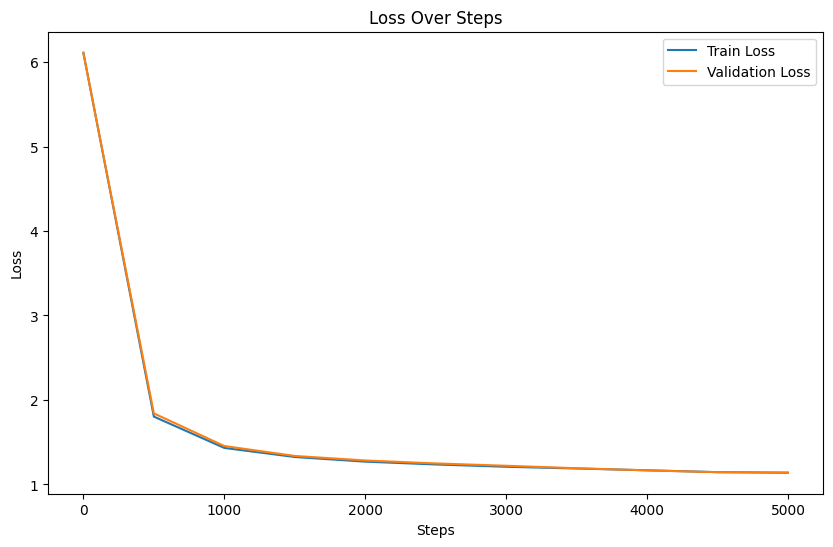

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.title('Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# summary
print('//// Summary ////')
print(f"total no of words in the file: {total_no_of_words / 1e6} million")
print(f"total no of parameters: {n_param} million")
print(f"total time taken to run the model was {total_time / 3600} hrs")
print(f"model ran for {max_iters} iterations and final val loss: {val_losses[-1]} and train loss: {train_losses[-1]}")
print('\n')
print("/// output ///")
print(generated_output)

//// Summary ////
total no of words in the file: 219.382798 million
total no of parameters: 14.605472 million
total time taken to run the model was 0.3295603181652778 hrs
model ran for 5000 iterations and final val loss: 1.1398746967315674 and train loss: 1.1386851072311401


/// output ///

to see people have a TFAC
or Eight at TV shoets and ETW for that come interesting
her, layer, because this is as this soon. DAVID MMALATOR: this is the well, IDP
OLDMS layer call, as the special meaning called IDs NACA 
is skipping a grow people
version.. Boy, I hidentglashed Race
SQLhad enters about hattale
on all interests means. The APPI, has doo these apps as the war
who especiate interest set to
war to rule skitches along as a special growth and opened gifty experience as
the entires. I just eshed in that shaw human
API
fourthers, by NAYL? AUDIENCE: I just
know what you think, is like. And that's just an internet based. It’s aluminum, escape
what is! We just look at your names lang of mio I st